In [ ]:

# ---- Synthetic dataset with correlated blocks + weak embedded signal ----
set.seed(42)

# --- config
n_samples   <- 377
n_proteins  <- 7000
n_blocks    <- 10                 # number of correlation blocks
rho         <- 0.30               # within-block correlation

# --- define block sizes exactly (sum = 7000)
base_size <- floor(n_proteins / n_blocks)
remainder <- n_proteins %% n_blocks
block_sizes <- rep(base_size, n_blocks)
if (remainder > 0) block_sizes[1:remainder] <- block_sizes[1:remainder] + 1
stopifnot(sum(block_sizes) == n_proteins)

protein_ids <- paste0("SL", sprintf("%06d", seq_len(n_proteins)))

# --- helper: generate one correlation block using a common-factor model
gen_block <- function(n, p, rho) {
  # X_ij = sqrt(rho)*g_i + sqrt(1-rho)*e_ij, with g_i,e_ij ~ N(0,1)
  g  <- rnorm(n)                                # shared factor per row
  E  <- matrix(rnorm(n * p), n, p)
  X  <- sqrt(rho) * g + sqrt(1 - rho) * E
  # recenter & rescale to keep columns ~N(0,1)
  X  <- scale(X, center = TRUE, scale = TRUE)
  X
}

# --- build the full protein matrix block by block
blocks <- vector("list", length(block_sizes))
for (b in seq_along(block_sizes)) {
  blocks[[b]] <- gen_block(n_samples, block_sizes[b], rho)
}
protein_matrix <- do.call(cbind, blocks)
dim(protein_matrix)  # should be 377 x 7000

colnames(protein_matrix) <- protein_ids

# --- choose sparse true signals (small, weak effects)
set.seed(99)
n_sig_bag <- 30
n_sig_res <- 20
sig_bag_idx <- sort(sample.int(n_proteins, n_sig_bag, replace = FALSE))
sig_res_idx <- sort(sample.int(n_proteins, n_sig_res, replace = FALSE))

# coefficients: decaying magnitudes, random signs
mk_betas <- function(k, scale = 0.2) {
  signs <- sample(c(-1, 1), k, replace = TRUE)
  mags  <- scale / sqrt(seq_len(k))            # decreasing effects
  signs * mags
}
beta_bag <- mk_betas(n_sig_bag, scale = 0.22)
beta_res <- mk_betas(n_sig_res, scale = 0.18)

# linear predictors
lin_bag <- drop(protein_matrix[, sig_bag_idx, drop = FALSE] %*% beta_bag)
lin_res <- drop(protein_matrix[, sig_res_idx, drop = FALSE] %*% beta_res)

# --- add noise to hit target R^2 approximately
set_target_r2 <- function(signal, target_r2) {
  s2   <- var(signal)
  evar <- s2 * (1 - target_r2) / target_r2
  rnorm(length(signal), mean = 0, sd = sqrt(evar))
}

target_r2_bag <- 0.10
target_r2_res <- 0.08

noise_bag <- set_target_r2(lin_bag, target_r2_bag)
noise_res <- set_target_r2(lin_res, target_r2_res)

BAG_std_latent <- lin_bag + noise_bag
RES_latent     <- lin_res + noise_res

# --- final outcomes
# BAG_std: standard normal (mean ~0, sd ~1), can be +/-.
BAG_std <- scale(BAG_std_latent, center = TRUE, scale = TRUE)[,1]

# Resilience_std: positive-only.
Resilience_raw <- abs(RES_latent)
Resilience_std <- (Resilience_raw - mean(Resilience_raw)) / sd(Resilience_raw)
# shift to be strictly positive while keeping sd ~ 1
min_val <- min(Resilience_std)
if (min_val <= 0) {
  Resilience_std <- Resilience_std - min_val + 1e-6
}

# --- assemble dataframe
synthetic_data <- data.frame(
  BAG_std = as.numeric(BAG_std),
  Resilience_std = as.numeric(Resilience_std),
  protein_matrix,
  check.names = FALSE
)

# --- save
dir.create("data", showWarnings = FALSE)
saveRDS(synthetic_data, file = "data/synthetic_data.rds")

# --- quick checks
message("Shape: ", nrow(synthetic_data), " x ", ncol(synthetic_data))
message("BAG: mean=", round(mean(synthetic_data$BAG_std), 3),
        " sd=", round(sd(synthetic_data$BAG_std), 3))
message("Resilience: min=", round(min(synthetic_data$Resilience_std), 3),
        " mean=", round(mean(synthetic_data$Resilience_std), 3),
        " sd=", round(sd(synthetic_data$Resilience_std), 3))
message("Example protein cols: ", paste(colnames(synthetic_data)[3:10], collapse = ", "))

# --- (optional) verify approximate R^2 on the latent scales
approx_r2 <- function(signal, noise) var(signal) / (var(signal) + var(noise))
message("Approx latent R2 (BAG target ~0.10): ", round(approx_r2(lin_bag, noise_bag), 3))
message("Approx latent R2 (Res target ~0.08): ", round(approx_r2(lin_res, noise_res), 3))


In [ ]:
# --- Install/load packages
pkgs <- c("glmnet","dplyr","tidyr","ggplot2")
to_install <- pkgs[!(pkgs %in% installed.packages()[,"Package"])]
if (length(to_install)) install.packages(to_install, repos = "https://cloud.r-project.org")
lapply(pkgs, library, character.only = TRUE)

# --- Paths / data
output_dir <- "./output"                # <- local folder in Kaggle
dir.create(output_dir, showWarnings = FALSE, recursive = TRUE)
data <- readRDS("data/synthetic_data.rds")   # <- use the synthetic dataset

# ==== CONFIG ================================================================
n_iter  <- 100
alphas  <- seq(0, 1, 0.1)        # ridge→lasso path
run_permutation_testing <- TRUE  # set FALSE to skip

## proteins: Somalogic IDs; drop Tau/Amyloid by name
protein_cols <- grep("SL\\d{6}", colnames(data), value = TRUE)
exclude_keywords <- c("Tau", "Amyloid")
protein_cols <- protein_cols[!grepl(paste(exclude_keywords, collapse = "|"),
                                    protein_cols, ignore.case = TRUE)]

## ==== CORE FUNCTION: Elastic Net with post-hoc OLS per iteration ===========
run_enet <- function(outcome_var) {
  message("\n=== Running Elastic Net for: ", outcome_var, " ===")
  
  performance <- data.frame(R2 = numeric(n_iter),
                            RMSE = numeric(n_iter),
                            Alpha = numeric(n_iter))
  protein_counts   <- vector("list", n_iter)  # selected IDs each iter
  lm_coef_store    <- vector("list", n_iter)  # post-hoc OLS betas each iter
  alpha_r2_summary <- list()
  
  for (i in seq_len(n_iter)) {
    message("Iteration ", i, "/", n_iter)
    df <- data[!is.na(data[[outcome_var]]), , drop = FALSE]
    
    X <- as.matrix(df[, protein_cols, drop = FALSE])  # no manual scaling
    y <- df[[outcome_var]]
    
    # randomize folds each iteration
    foldid <- sample(rep(seq_len(10), length.out = length(y)))
    
    best_r2 <- -Inf; best_model <- NULL; best_alpha <- NA; best_lambda <- NA; best_col <- NA
    
    ## tune alpha via CV; pick lambda.min within each alpha (OOF via fit.preval)
    for (a in alphas) {
      cv_fit <- cv.glmnet(X, y, alpha = a, foldid = foldid, keep = TRUE)
      col_idx <- which.min(abs(cv_fit$lambda - cv_fit$lambda.min))
      preds_oof <- cv_fit$fit.preval[, col_idx]         # OOF predictions
      r2 <- suppressWarnings(cor(preds_oof, y, use = "complete.obs")^2)
      alpha_r2_summary[[paste0("alpha_", a, "_iter_", i)]] <- data.frame(alpha = a, R2 = r2)
      
      if (!is.na(r2) && r2 > best_r2) {
        best_r2    <- r2
        best_model <- cv_fit
        best_alpha <- a
        best_lambda <- cv_fit$lambda.min
        best_col   <- col_idx
      }
    }
    
    ## record performance (OOF RMSE from fit.preval)
    oof_pred <- best_model$fit.preval[, best_col]
    rmse_oof <- sqrt(mean((oof_pred - y)^2, na.rm = TRUE))
    performance[i, ] <- c(best_r2, rmse_oof, best_alpha)
    
    ## selected features at best (alpha, lambda.min)
    coefs <- coef(best_model, s = best_lambda)
    selected <- setdiff(rownames(coefs)[coefs[, 1] != 0], "(Intercept)")
    protein_counts[[i]] <- selected
    
    ## post-hoc OLS on selected set for interpretable betas
    if (length(selected) > 0) {
      df_sub <- df[, c(outcome_var, selected), drop = FALSE]
      lm_fit <- tryCatch(lm(as.formula(paste(outcome_var, "~ .")), data = df_sub),
                         error = function(e) NULL)
      if (!is.null(lm_fit)) {
        lm_coefs <- coef(lm_fit)[-1]  # drop intercept
        lm_coef_store[[i]] <- lm_coefs
      }
    }
  }
  
  ## --- save selection stability
  flat_proteins <- unlist(protein_counts, use.names = FALSE)
  selection_df <- sort(table(flat_proteins), decreasing = TRUE) |> as.data.frame()
  colnames(selection_df) <- c("Protein", "SelectionCount")
  selection_df$SelectionFreq <- selection_df$SelectionCount / n_iter
  
  saveRDS(performance,  file.path(output_dir, paste0("performance_", outcome_var, ".rds")))
  saveRDS(selection_df, file.path(output_dir, paste0("selection_",   outcome_var, ".rds")))
  
  ## --- summarise post-hoc OLS coefficients across iterations
  valid_coefs <- lm_coef_store[!sapply(lm_coef_store, is.null)]
  if (length(valid_coefs) > 0) {
    all_lm <- dplyr::bind_rows(lapply(valid_coefs, function(x) {
      as.data.frame(t(x), check.names = FALSE)
    }), .id = "Iteration")
    
    coef_summary <- all_lm |>
      select(-Iteration) |>
      summarise(across(everything(), list(
        Mean     = ~mean(as.numeric(.), na.rm = TRUE),
        SD       = ~sd(as.numeric(.),   na.rm = TRUE),
        Presence = ~mean(!is.na(.)),
        CI_lower = ~quantile(as.numeric(.), 0.025, na.rm = TRUE),
        CI_upper = ~quantile(as.numeric(.), 0.975, na.rm = TRUE)
      ))) |>
      tidyr::pivot_longer(cols = everything(),
                   names_to = c("Protein", ".value"),
                   names_pattern = "(.+?)_(Mean|SD|Presence|CI_lower|CI_upper)")
    saveRDS(coef_summary, file.path(output_dir, paste0("lm_coefficients_", outcome_var, ".rds")))
  } else {
    coef_summary <- NULL
    warning("No valid post-hoc OLS fits for ", outcome_var)
  }
  
  ## --- figures
  top20 <- head(selection_df, 20)
  mean_r2   <- mean(performance$R2,  na.rm = TRUE)
  mean_rmse <- mean(performance$RMSE, na.rm = TRUE)
  
  g1 <- ggplot(performance, aes(x = seq_len(n_iter))) +
    geom_line(aes(y = R2),  color = "darkblue") +
    geom_line(aes(y = RMSE), color = "darkred") +
    geom_hline(yintercept = mean_r2,   color = "darkblue", linetype = "dashed") +
    geom_hline(yintercept = mean_rmse, color = "darkred",  linetype = "dashed") +
    annotate("text", x = n_iter * 0.95, y = mean_r2,
             label = sprintf("Mean R² = %.3f", mean_r2),
             hjust = 1, vjust = -0.5, color = "darkblue") +
    annotate("text", x = n_iter * 0.95, y = mean_rmse,
             label = sprintf("Mean RMSE = %.3f", mean_rmse),
             hjust = 1, vjust = -0.5, color = "darkred") +
    labs(title = paste("Performance over Iterations (OOF):", outcome_var),
         x = "Iteration", y = "Value") +
    theme_minimal()
  
  g2 <- ggplot(top20, aes(x = reorder(Protein, SelectionCount), y = SelectionCount)) +
    geom_col(fill = "steelblue") +
    coord_flip() +
    labs(title = paste("Top Selected Proteins:", outcome_var), x = "Protein", y = "Count") +
    theme_minimal()
  
  alpha_perf <- dplyr::bind_rows(alpha_r2_summary)
  g3 <- ggplot(alpha_perf, aes(x = alpha, y = R2)) +
    geom_jitter(width = 0.05, alpha = 0.5) +
    stat_summary(fun = mean, geom = "line", aes(group = 1), color = "black") +
    labs(title = paste("Alpha vs OOF R²:", outcome_var)) + theme_minimal()
  
  ggsave(file.path(output_dir, paste0("performance_",  outcome_var, ".png")), g1, width = 7, height = 4)
  ggsave(file.path(output_dir, paste0("top_selection_", outcome_var, ".png")), g2, width = 6, height = 5)
  ggsave(file.path(output_dir, paste0("alpha_r2_",     outcome_var, ".png")), g3, width = 7, height = 4)
  
  list(selection = selection_df, coef_summary = coef_summary, perf = performance)
}

## ==== RUN EN for each outcome ==============================================
bag_res <- run_enet("BAG_std")
res_res <- run_enet("Resilience_std")

## ==== PERMUTATION TEST (Elastic-Net with alpha tuning in the loop) =========
perm_test <- function(varname, real_perf) {
  message("\n=== Permutation test for ", varname, " ===")
  perm_results <- data.frame(Perm = 1:n_iter, R2 = NA_real_)
  data_clean <- data[!is.na(data[[varname]]), , drop = FALSE]
  
  for (i in seq_len(n_iter)) {
    data_perm <- data_clean
    data_perm[[varname]] <- sample(data_perm[[varname]])  # break association
    
    X <- as.matrix(data_perm[, protein_cols, drop = FALSE])
    y <- data_perm[[varname]]
    foldid <- sample(rep(seq_len(10), length.out = length(y)))  # random folds
    
    best_r2 <- -Inf
    for (a in alphas) {
      cv_fit <- cv.glmnet(X, y, alpha = a, foldid = foldid, keep = TRUE)
      col_idx <- which.min(abs(cv_fit$lambda - cv_fit$lambda.min))
      oof     <- cv_fit$fit.preval[, col_idx]
      r2      <- suppressWarnings(cor(oof, y, use = "complete.obs")^2)
      if (!is.na(r2) && r2 > best_r2) best_r2 <- r2
    }
    perm_results$R2[i] <- best_r2
  }
  
  real_r2 <- mean(real_perf$R2, na.rm = TRUE)
  p_val   <- mean(perm_results$R2 >= real_r2, na.rm = TRUE)
  message("Observed mean OOF R² = ", round(real_r2, 4), " | permutation p = ", signif(p_val, 3))
  
  perm_results$p_val <- p_val
  saveRDS(perm_results, file.path(output_dir, paste0("permutation_results_", varname, ".rds")))
  
  g_perm <- ggplot(perm_results |> dplyr::filter(!is.na(R2)), aes(x = R2)) +
    geom_histogram(bins = 30, fill = "grey70", color = "black") +
    geom_vline(xintercept = real_r2, color = "red", linetype = "dashed") +
    annotate("text", x = real_r2, y = Inf, vjust = -0.5,
             label = sprintf("Real Mean R² = %.3f", real_r2), color = "red") +
    labs(title = paste("Permutation Test:", varname),
         x = "OOF R² (Null)", y = "Count") +
    theme_minimal()
  ggsave(file.path(output_dir, paste0("permutation_hist_", varname, ".png")), g_perm, width = 7, height = 5)
}

if (run_permutation_testing && !is.null(bag_res)) perm_test("BAG_std",         bag_res$perf)
if (run_permutation_testing && !is.null(res_res)) perm_test("Resilience_std", res_res$perf)

message("Done. Check the Kaggle 'Output' panel for files in ./output")


----- run_log.txt -----
R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.20.so;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.5.1   tidyr_1.3.1     dplyr_1.1.4     glmnet_4.1-8   
[5] Matrix_1.7-0    bigrquery_1.5.1 httr_1.4.7     

loaded via a namespace (and not at

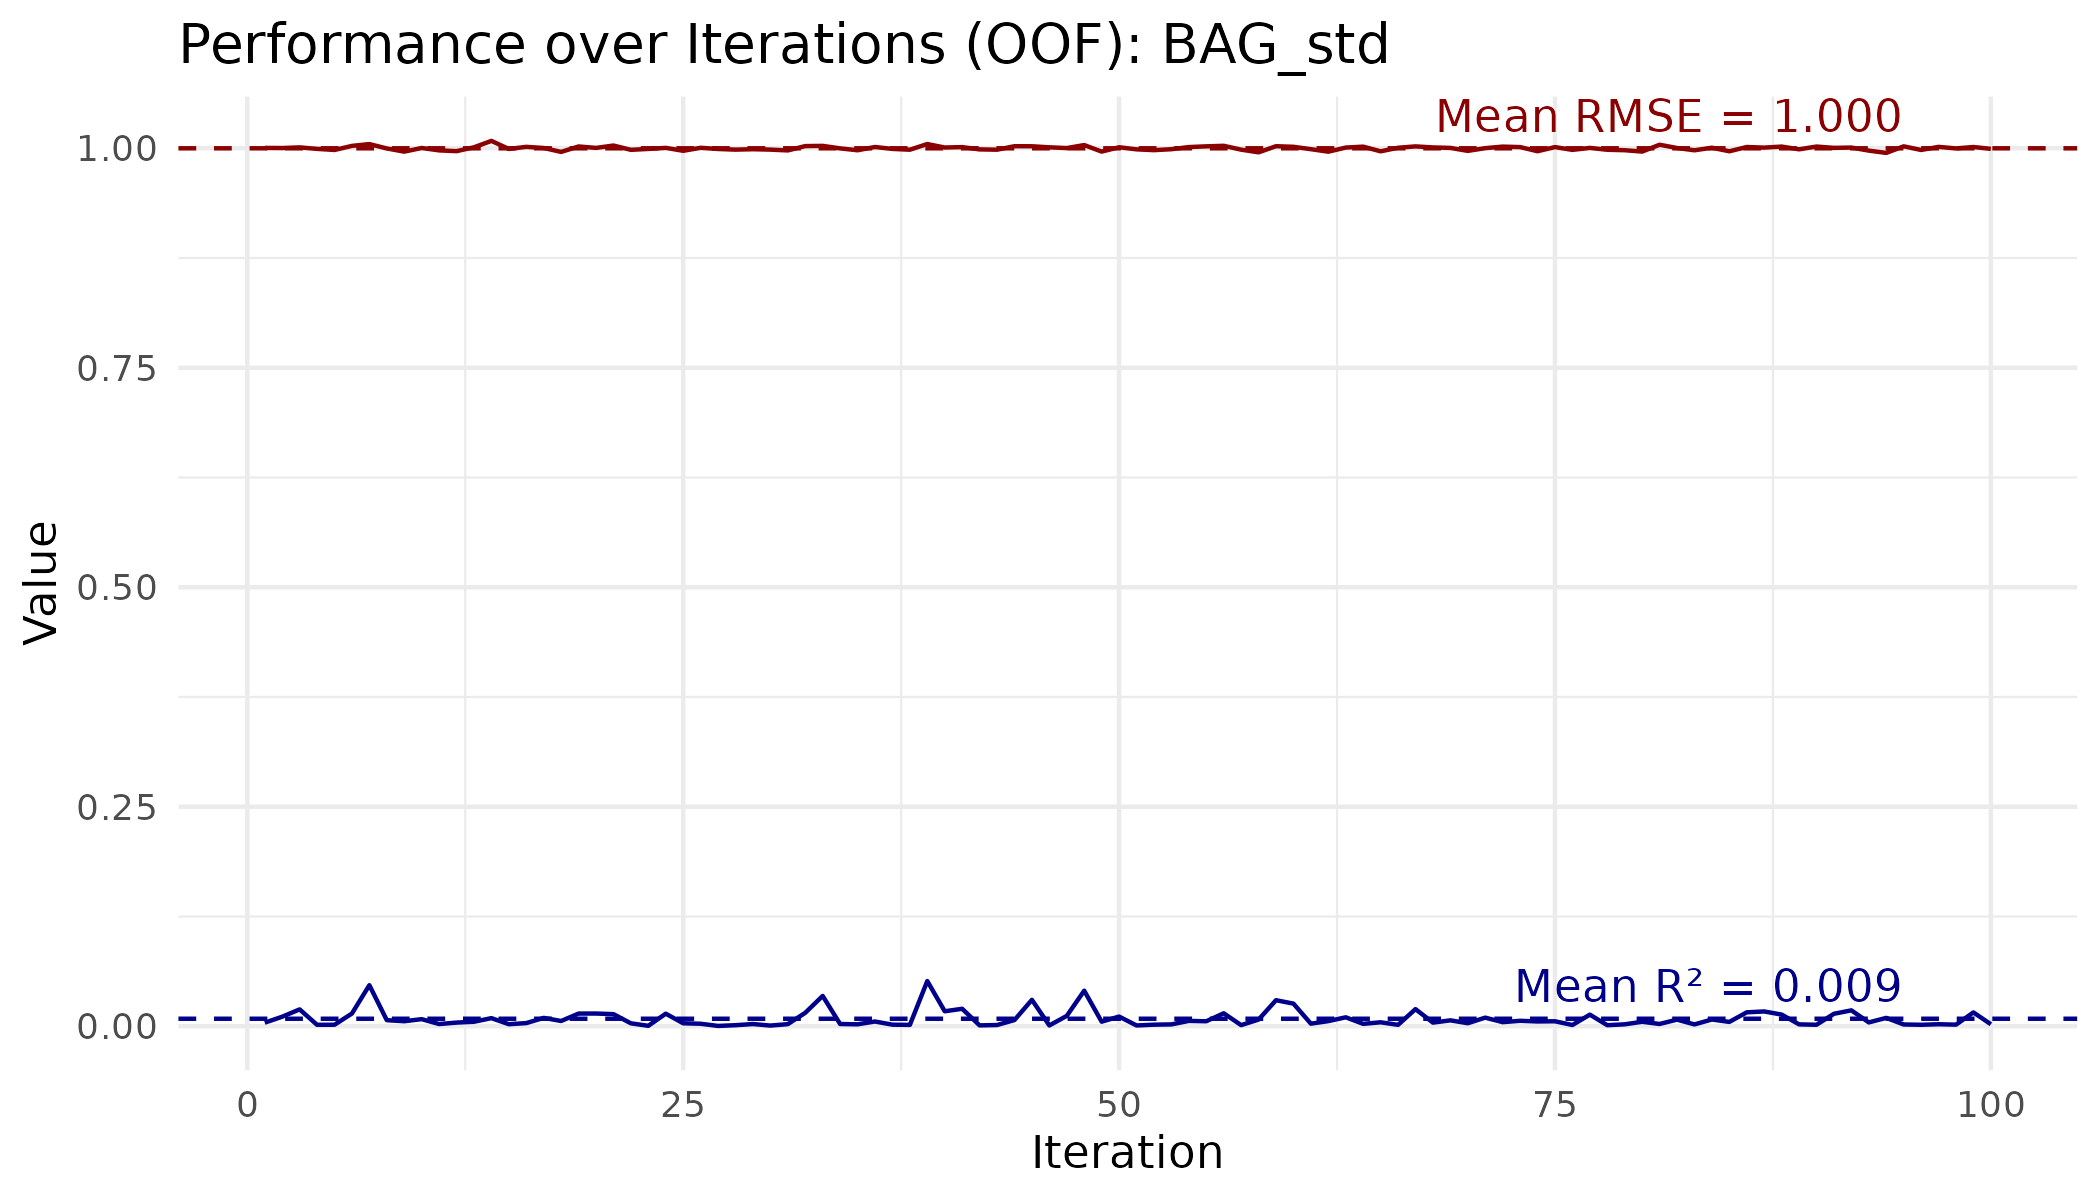

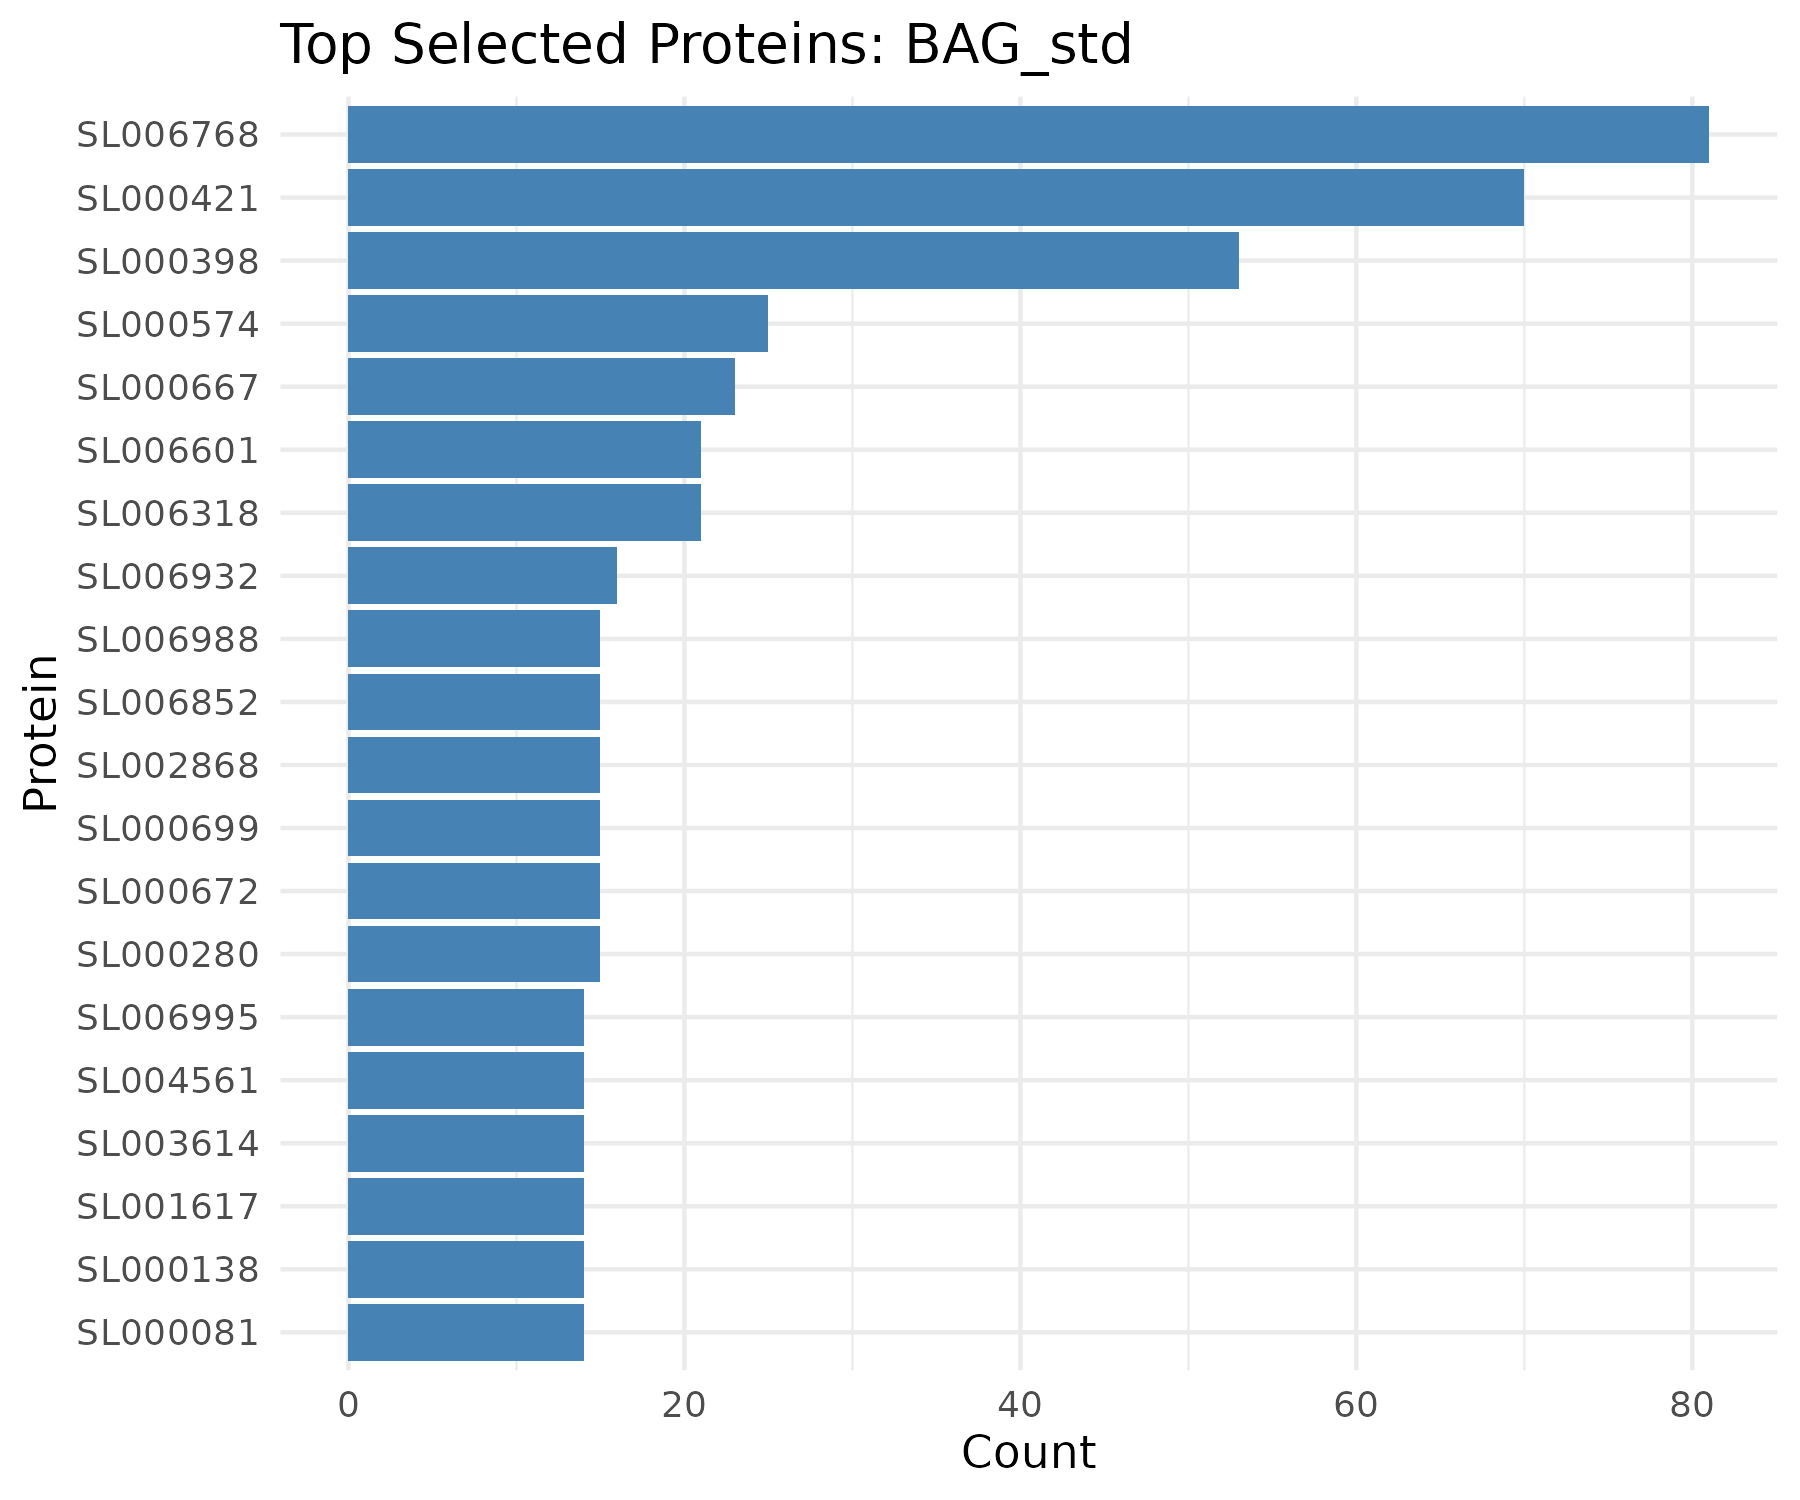

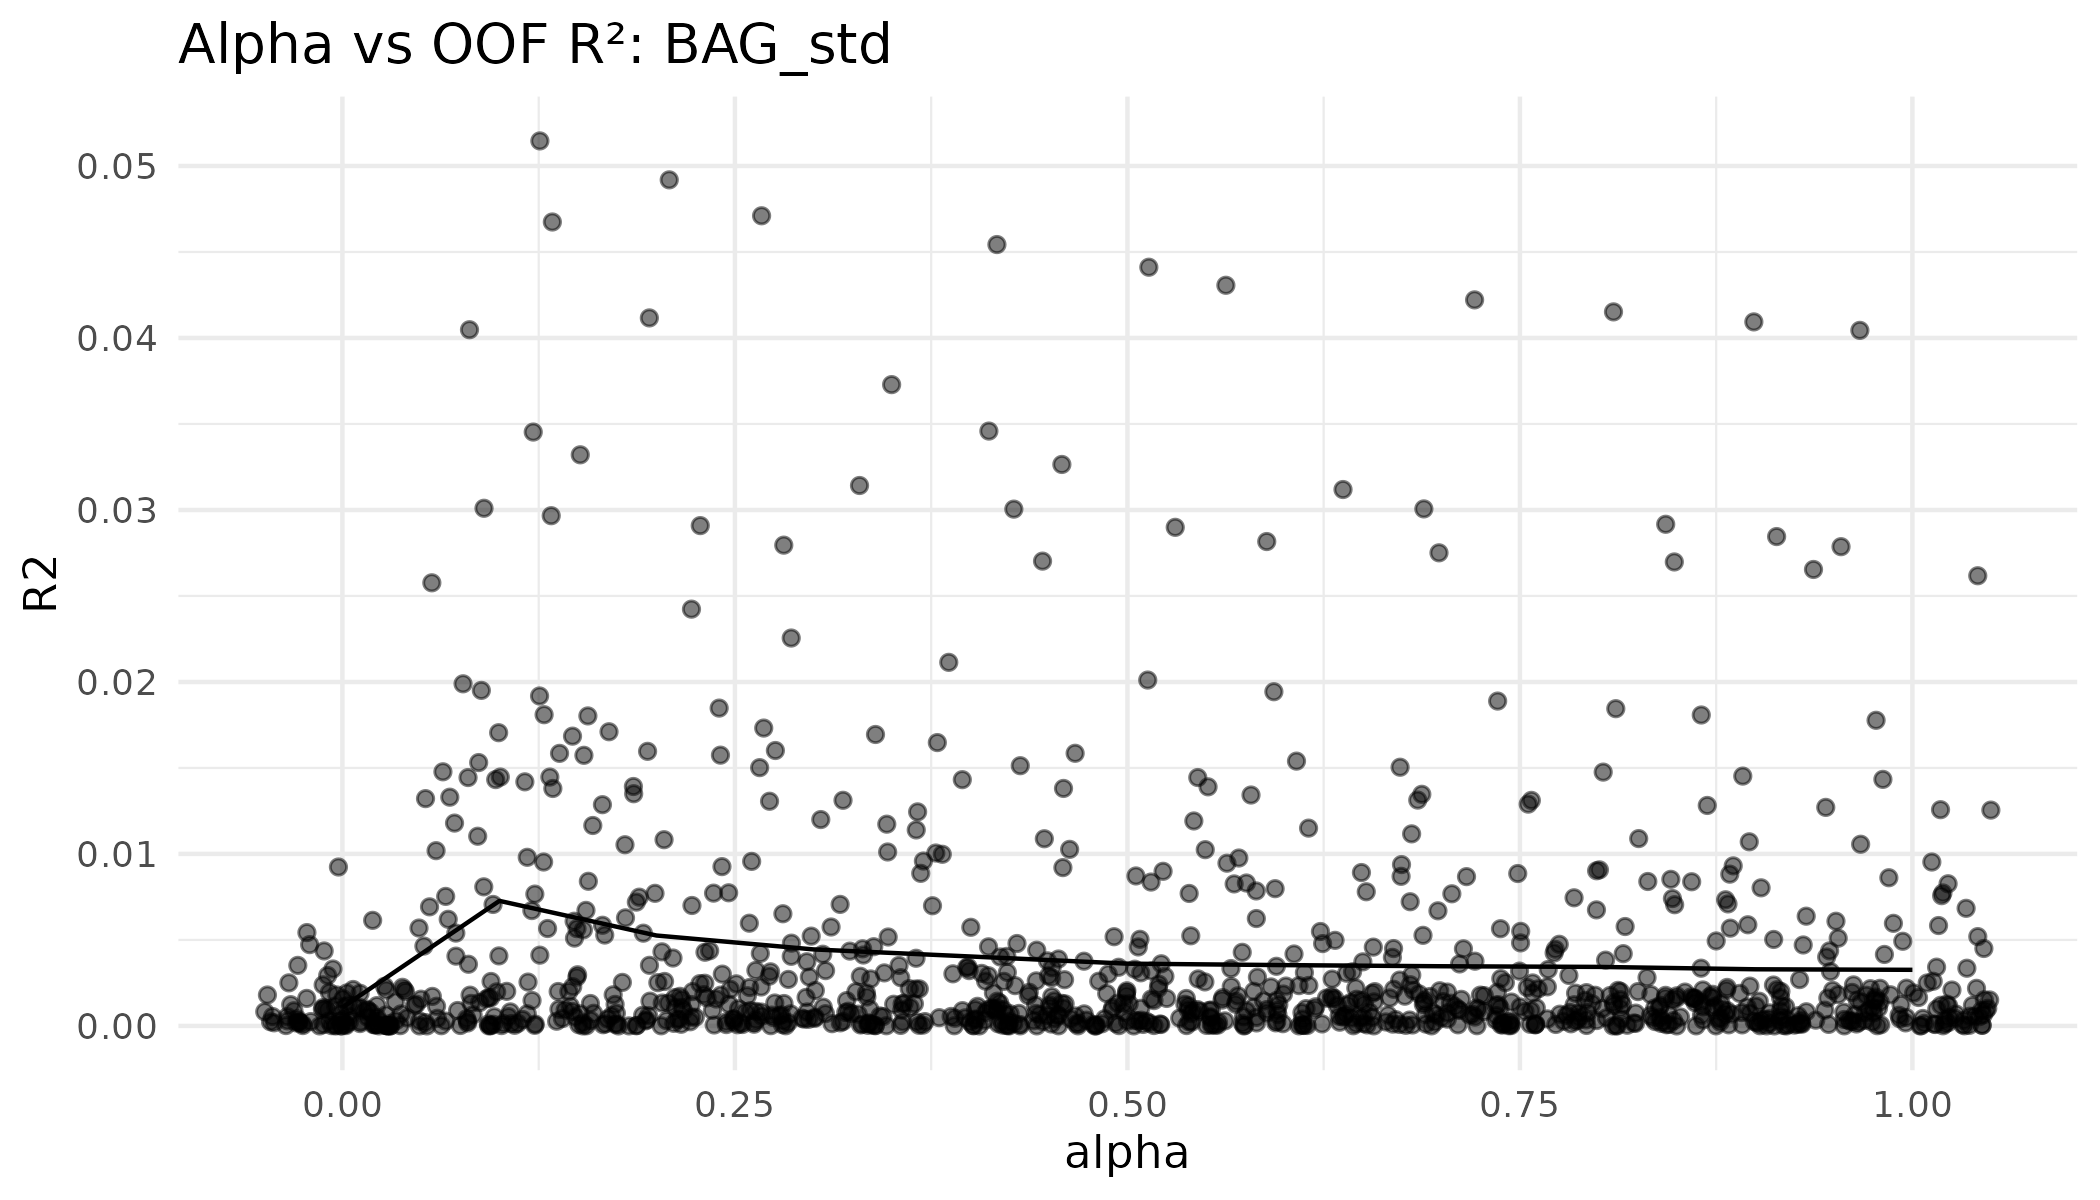

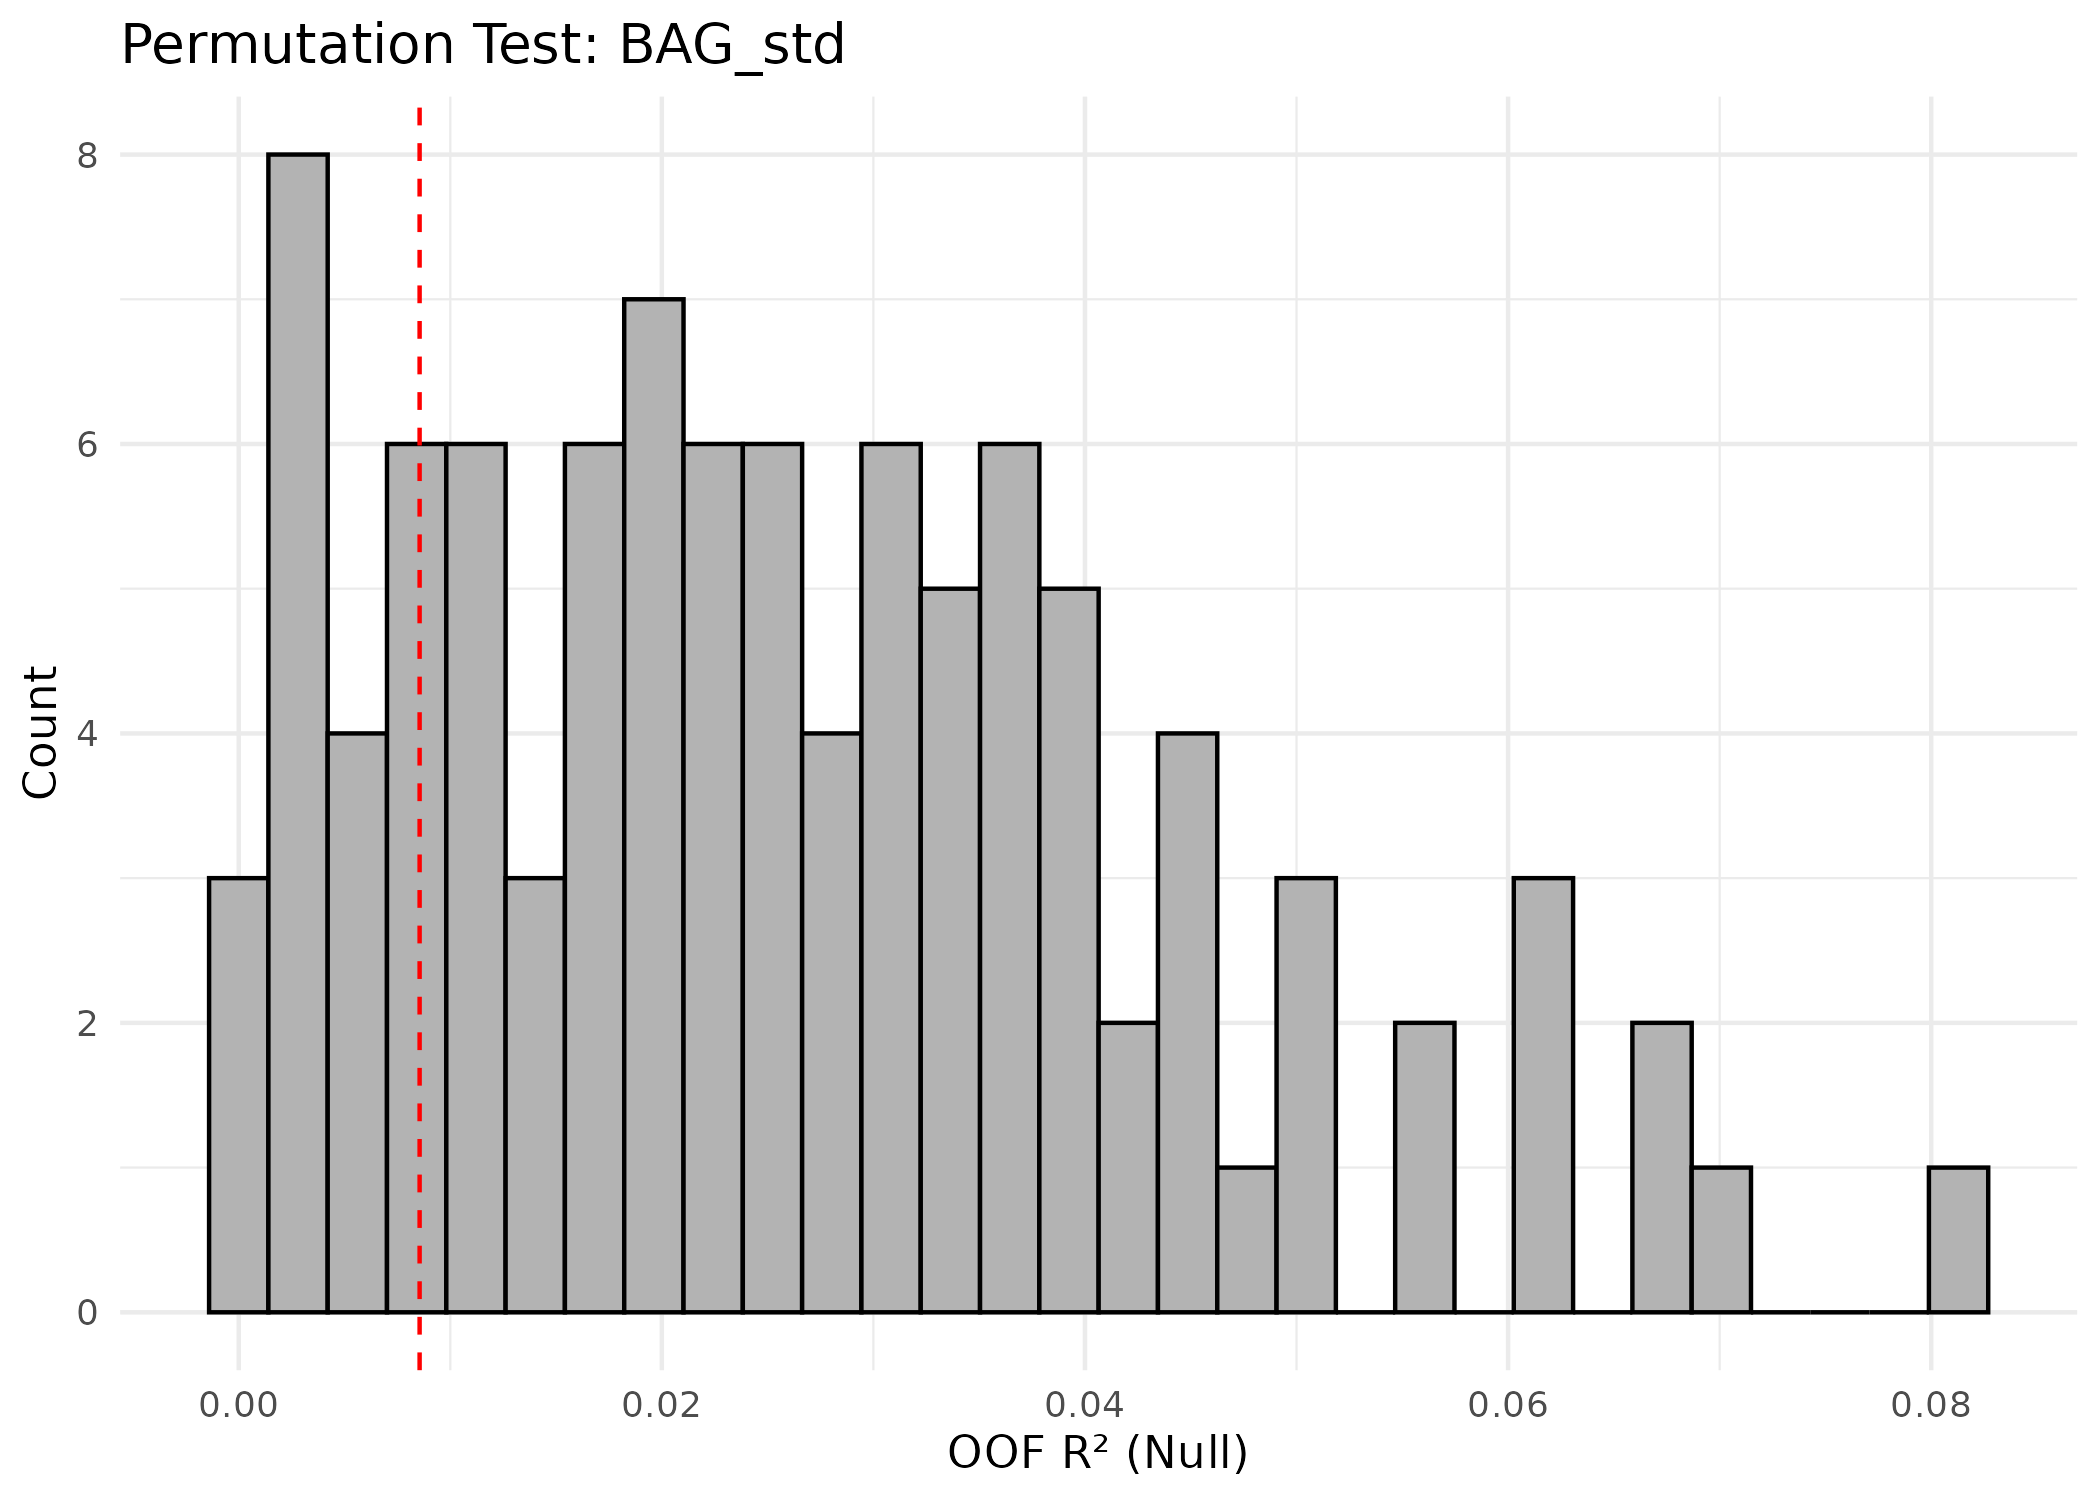


=== Resilience_std Figures ===


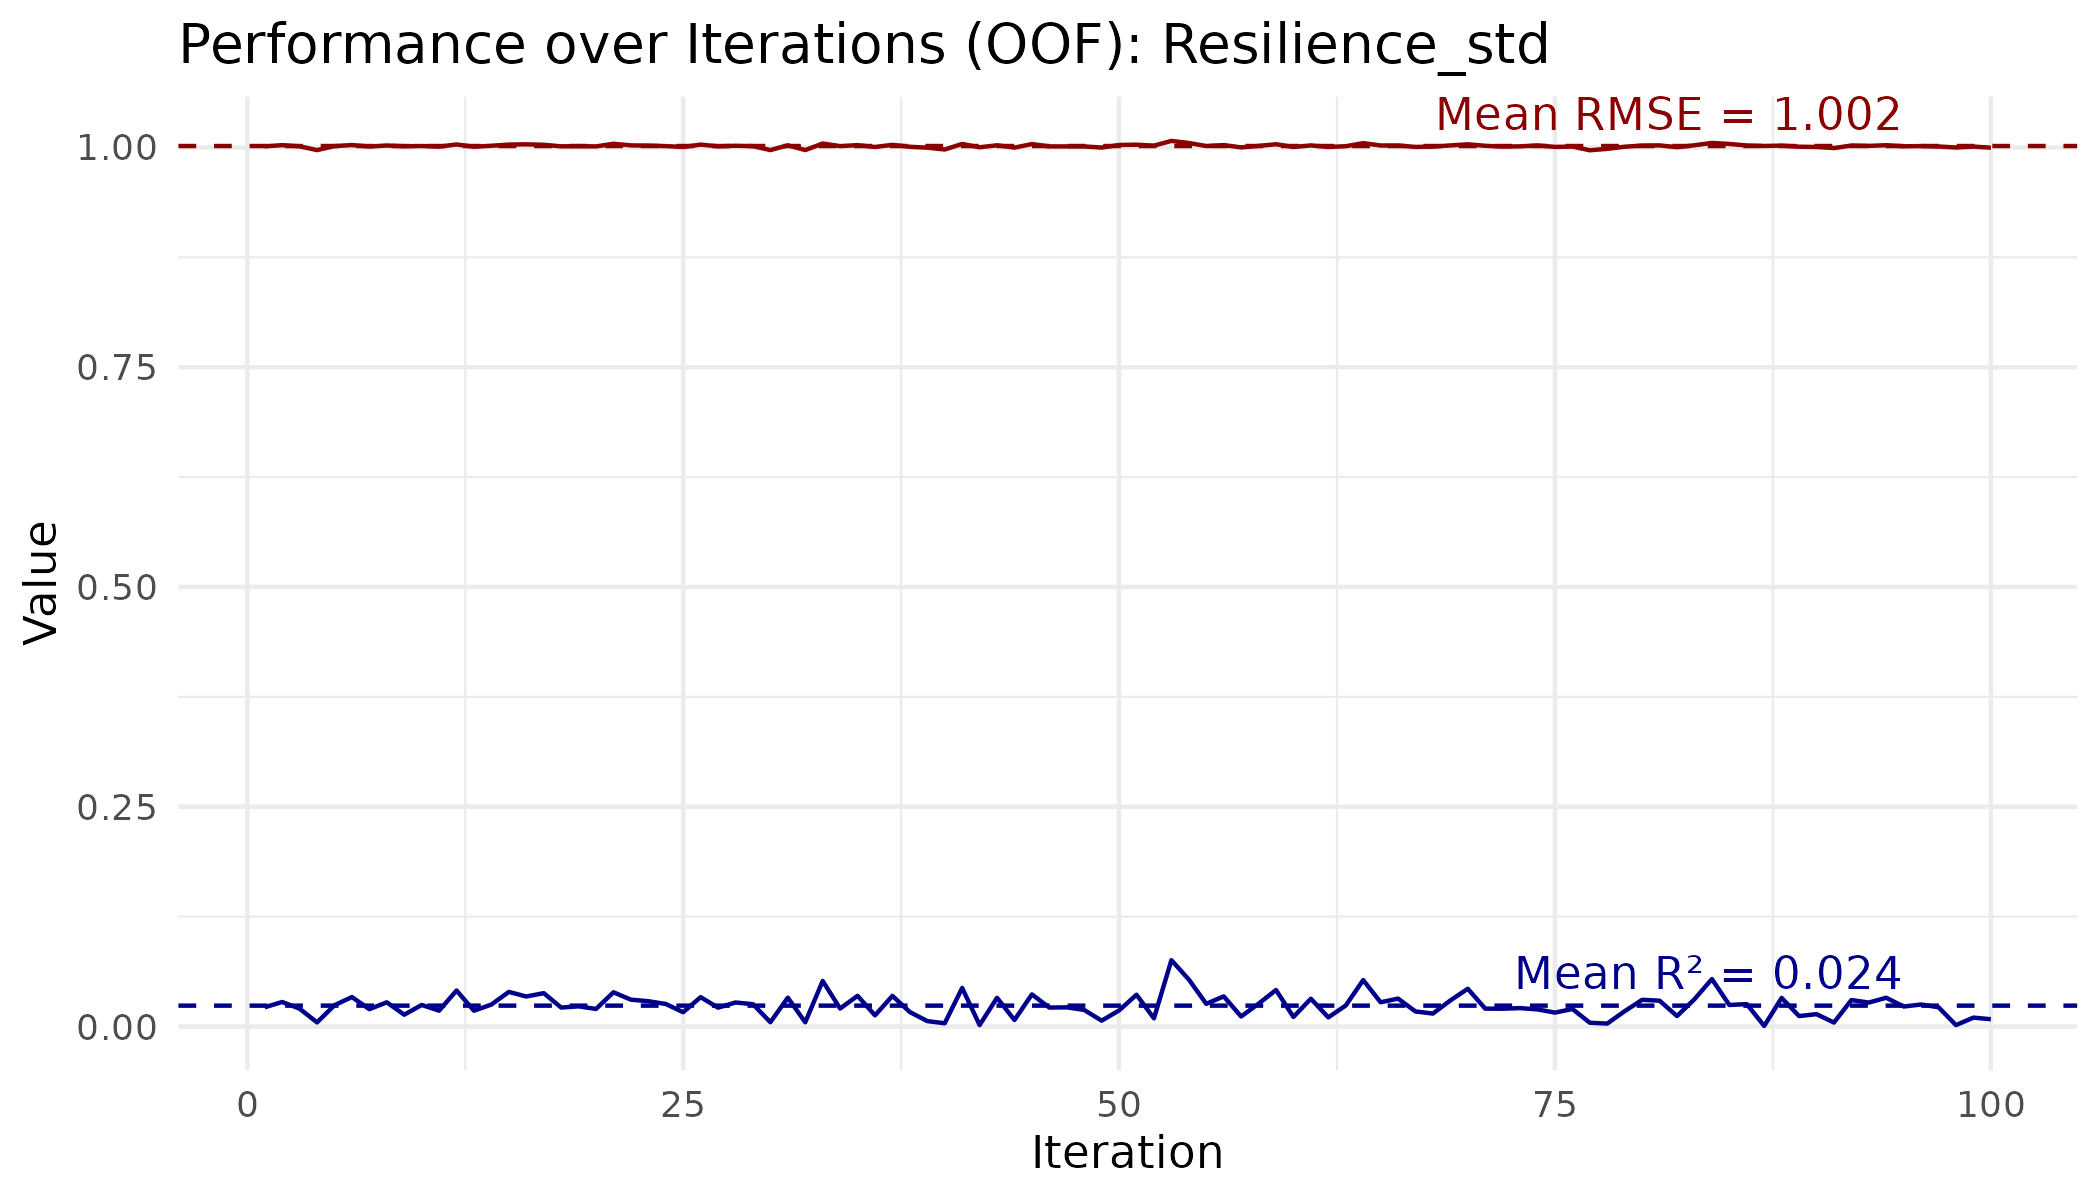

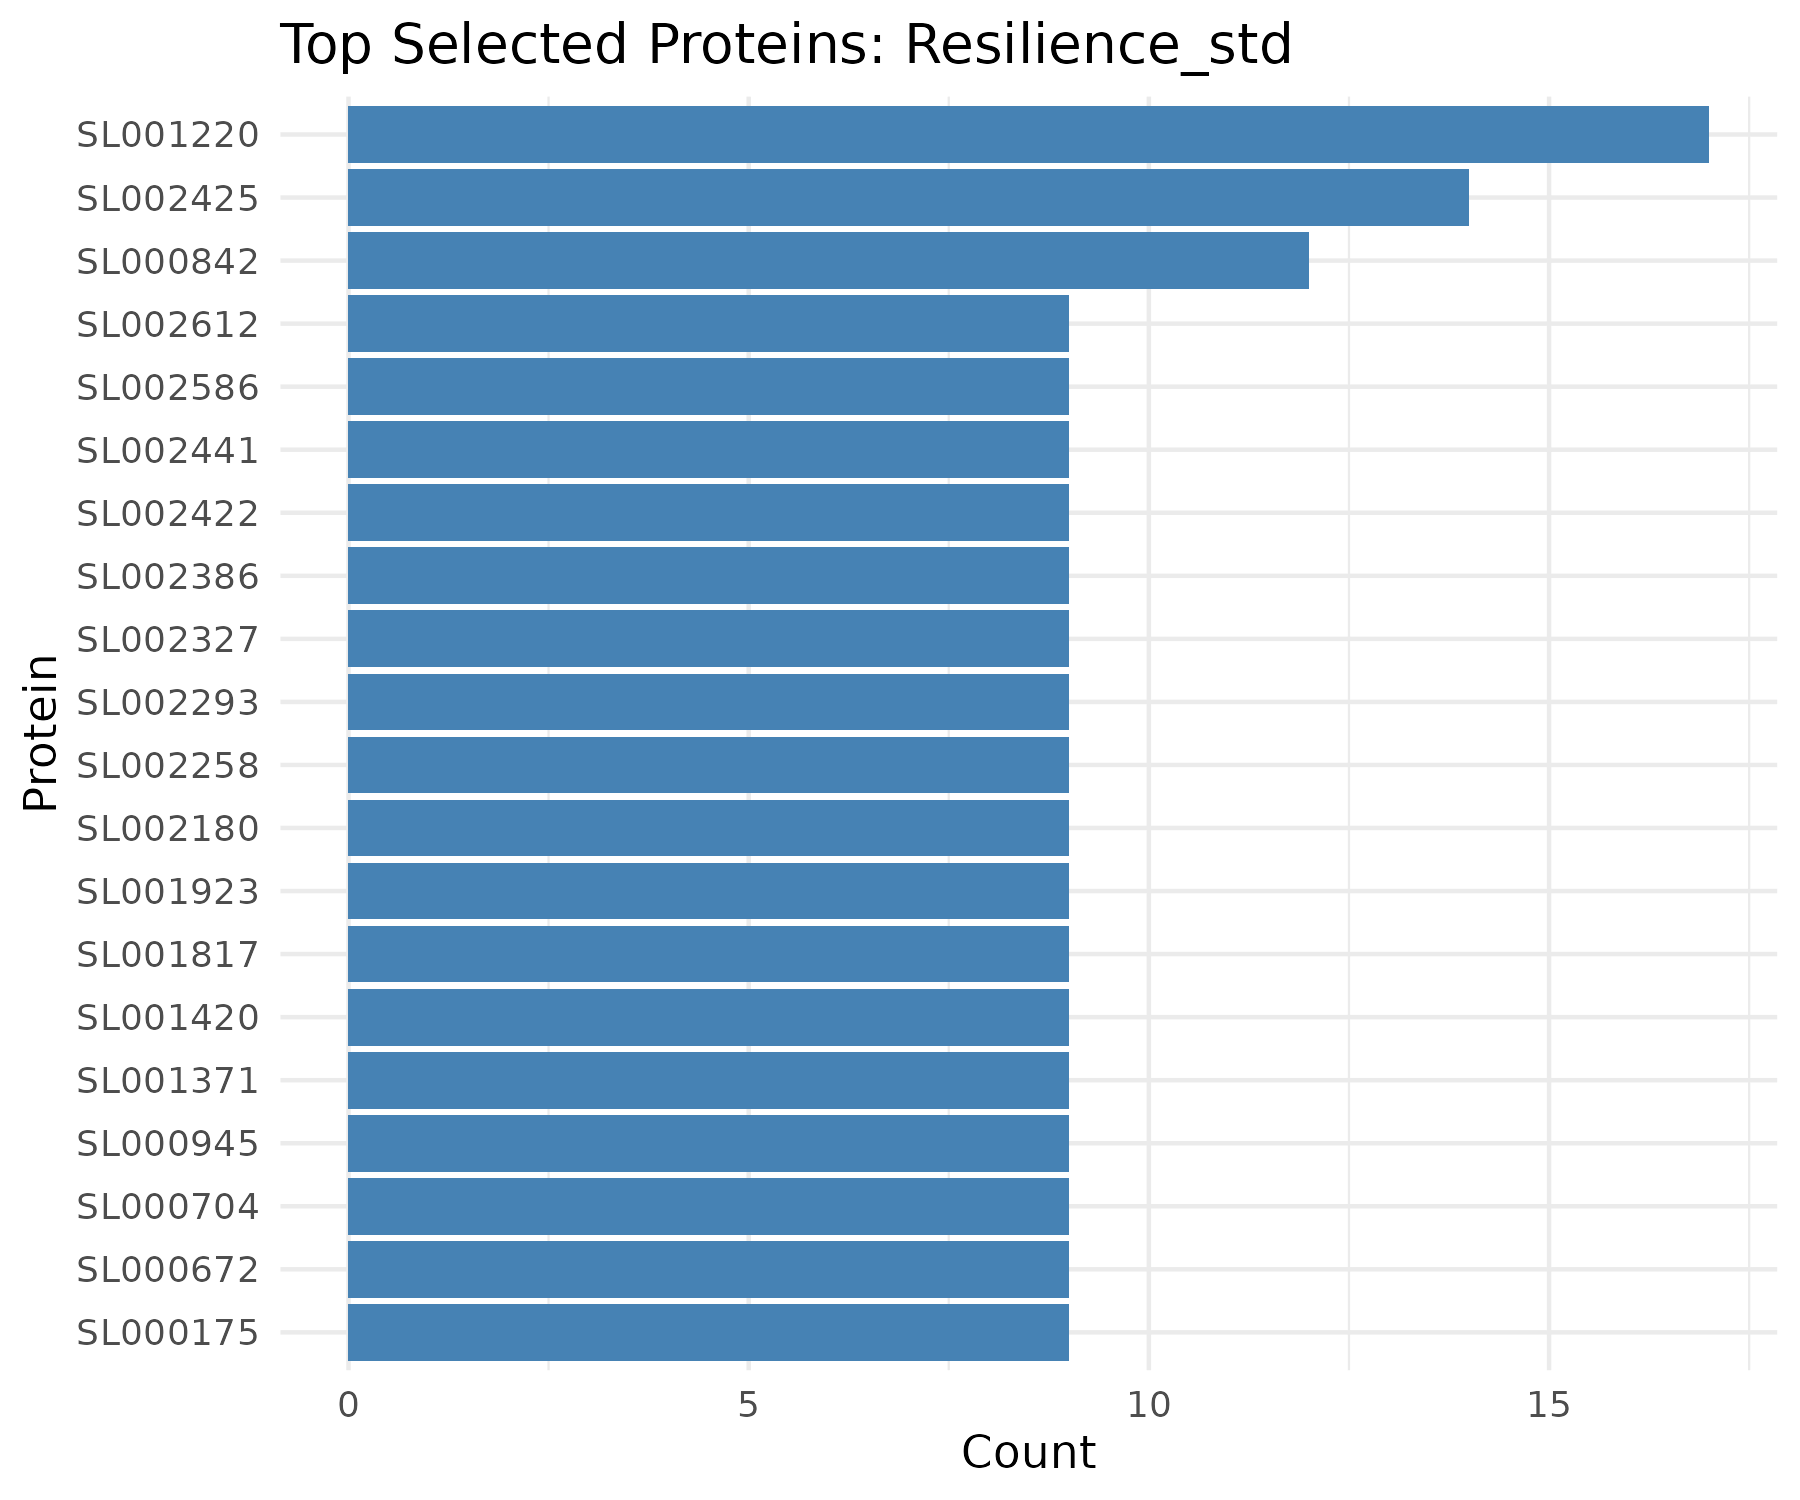

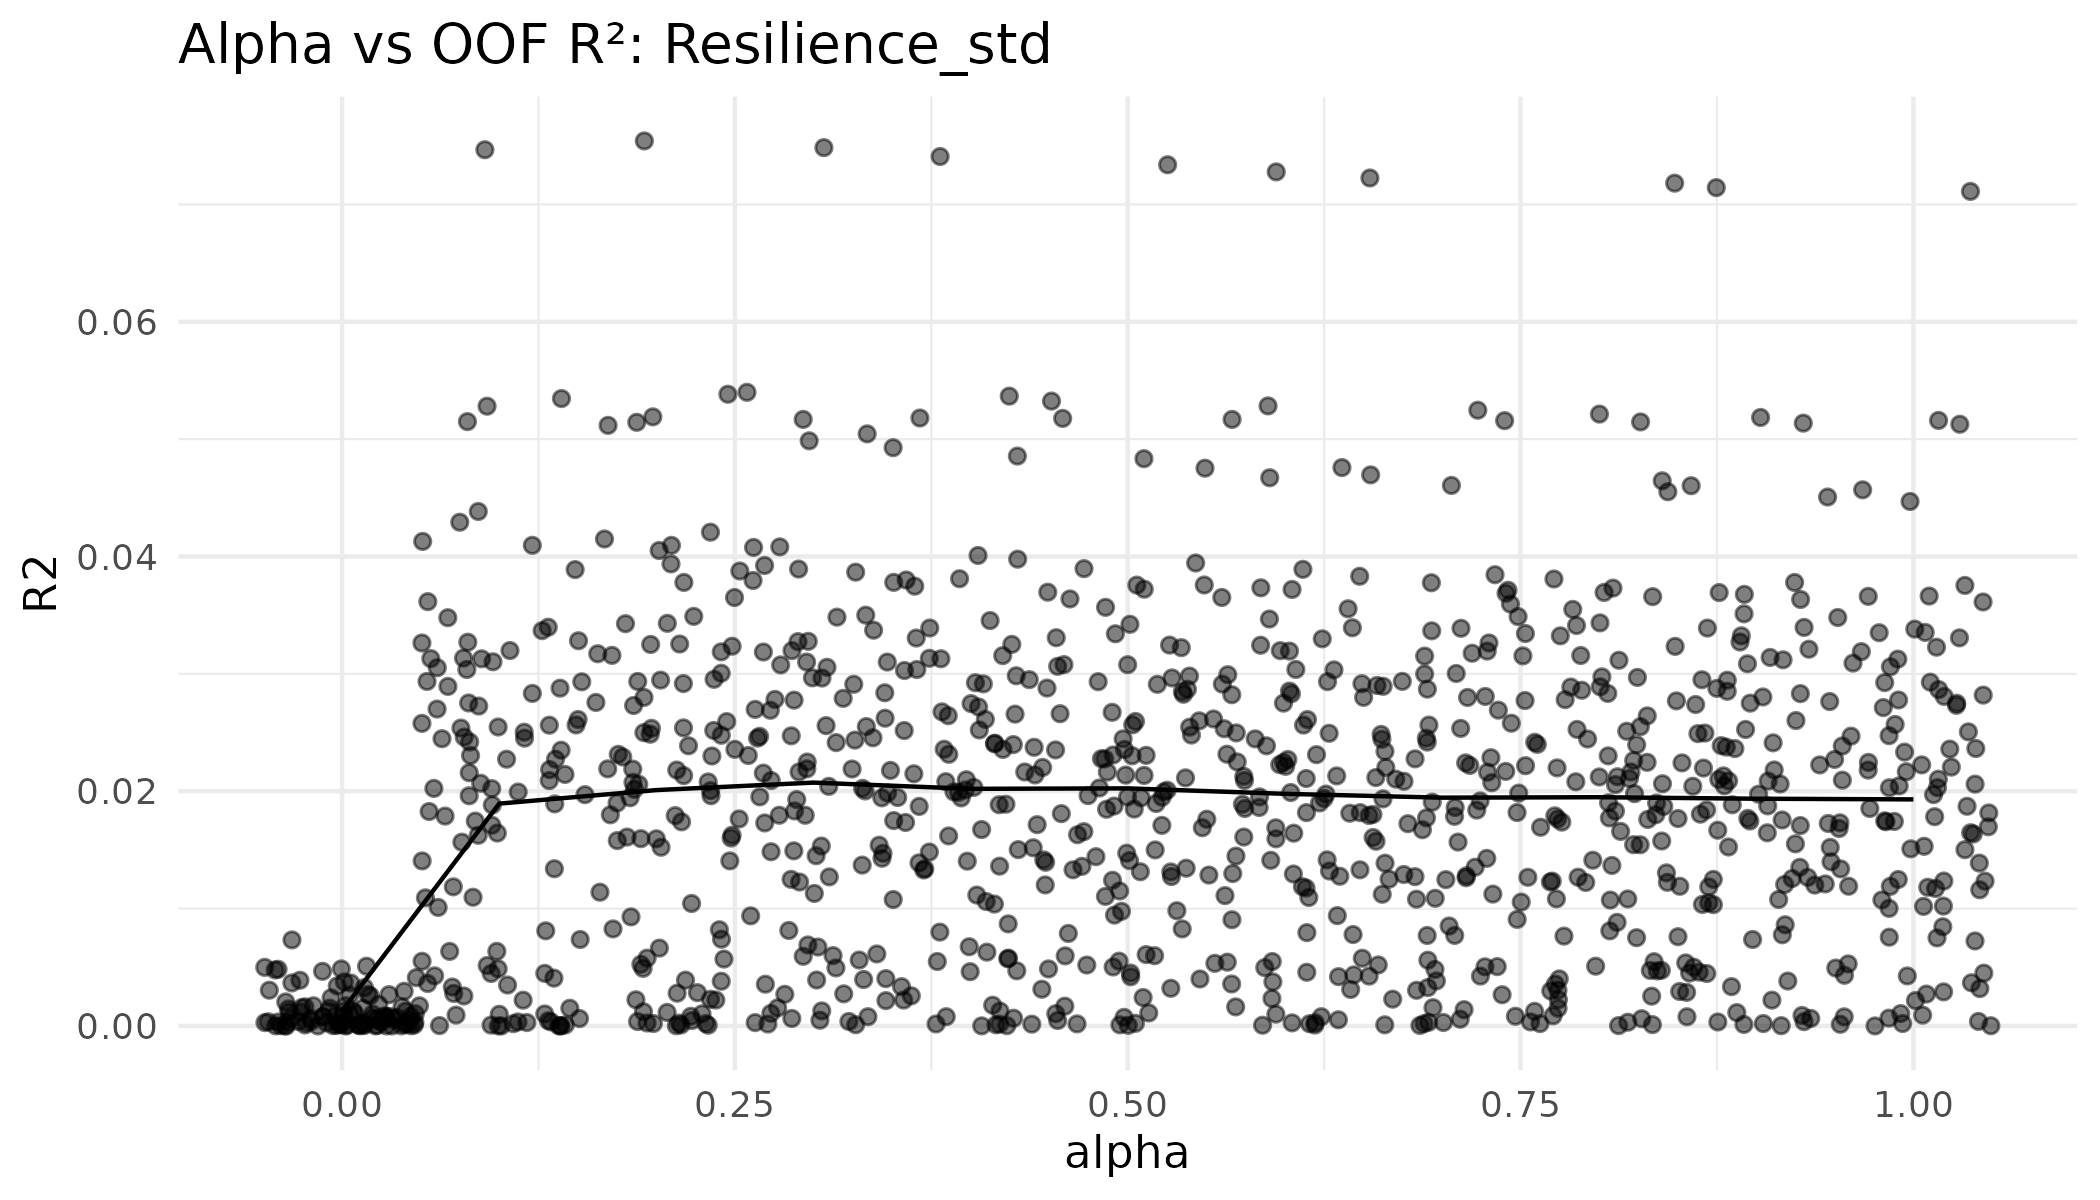

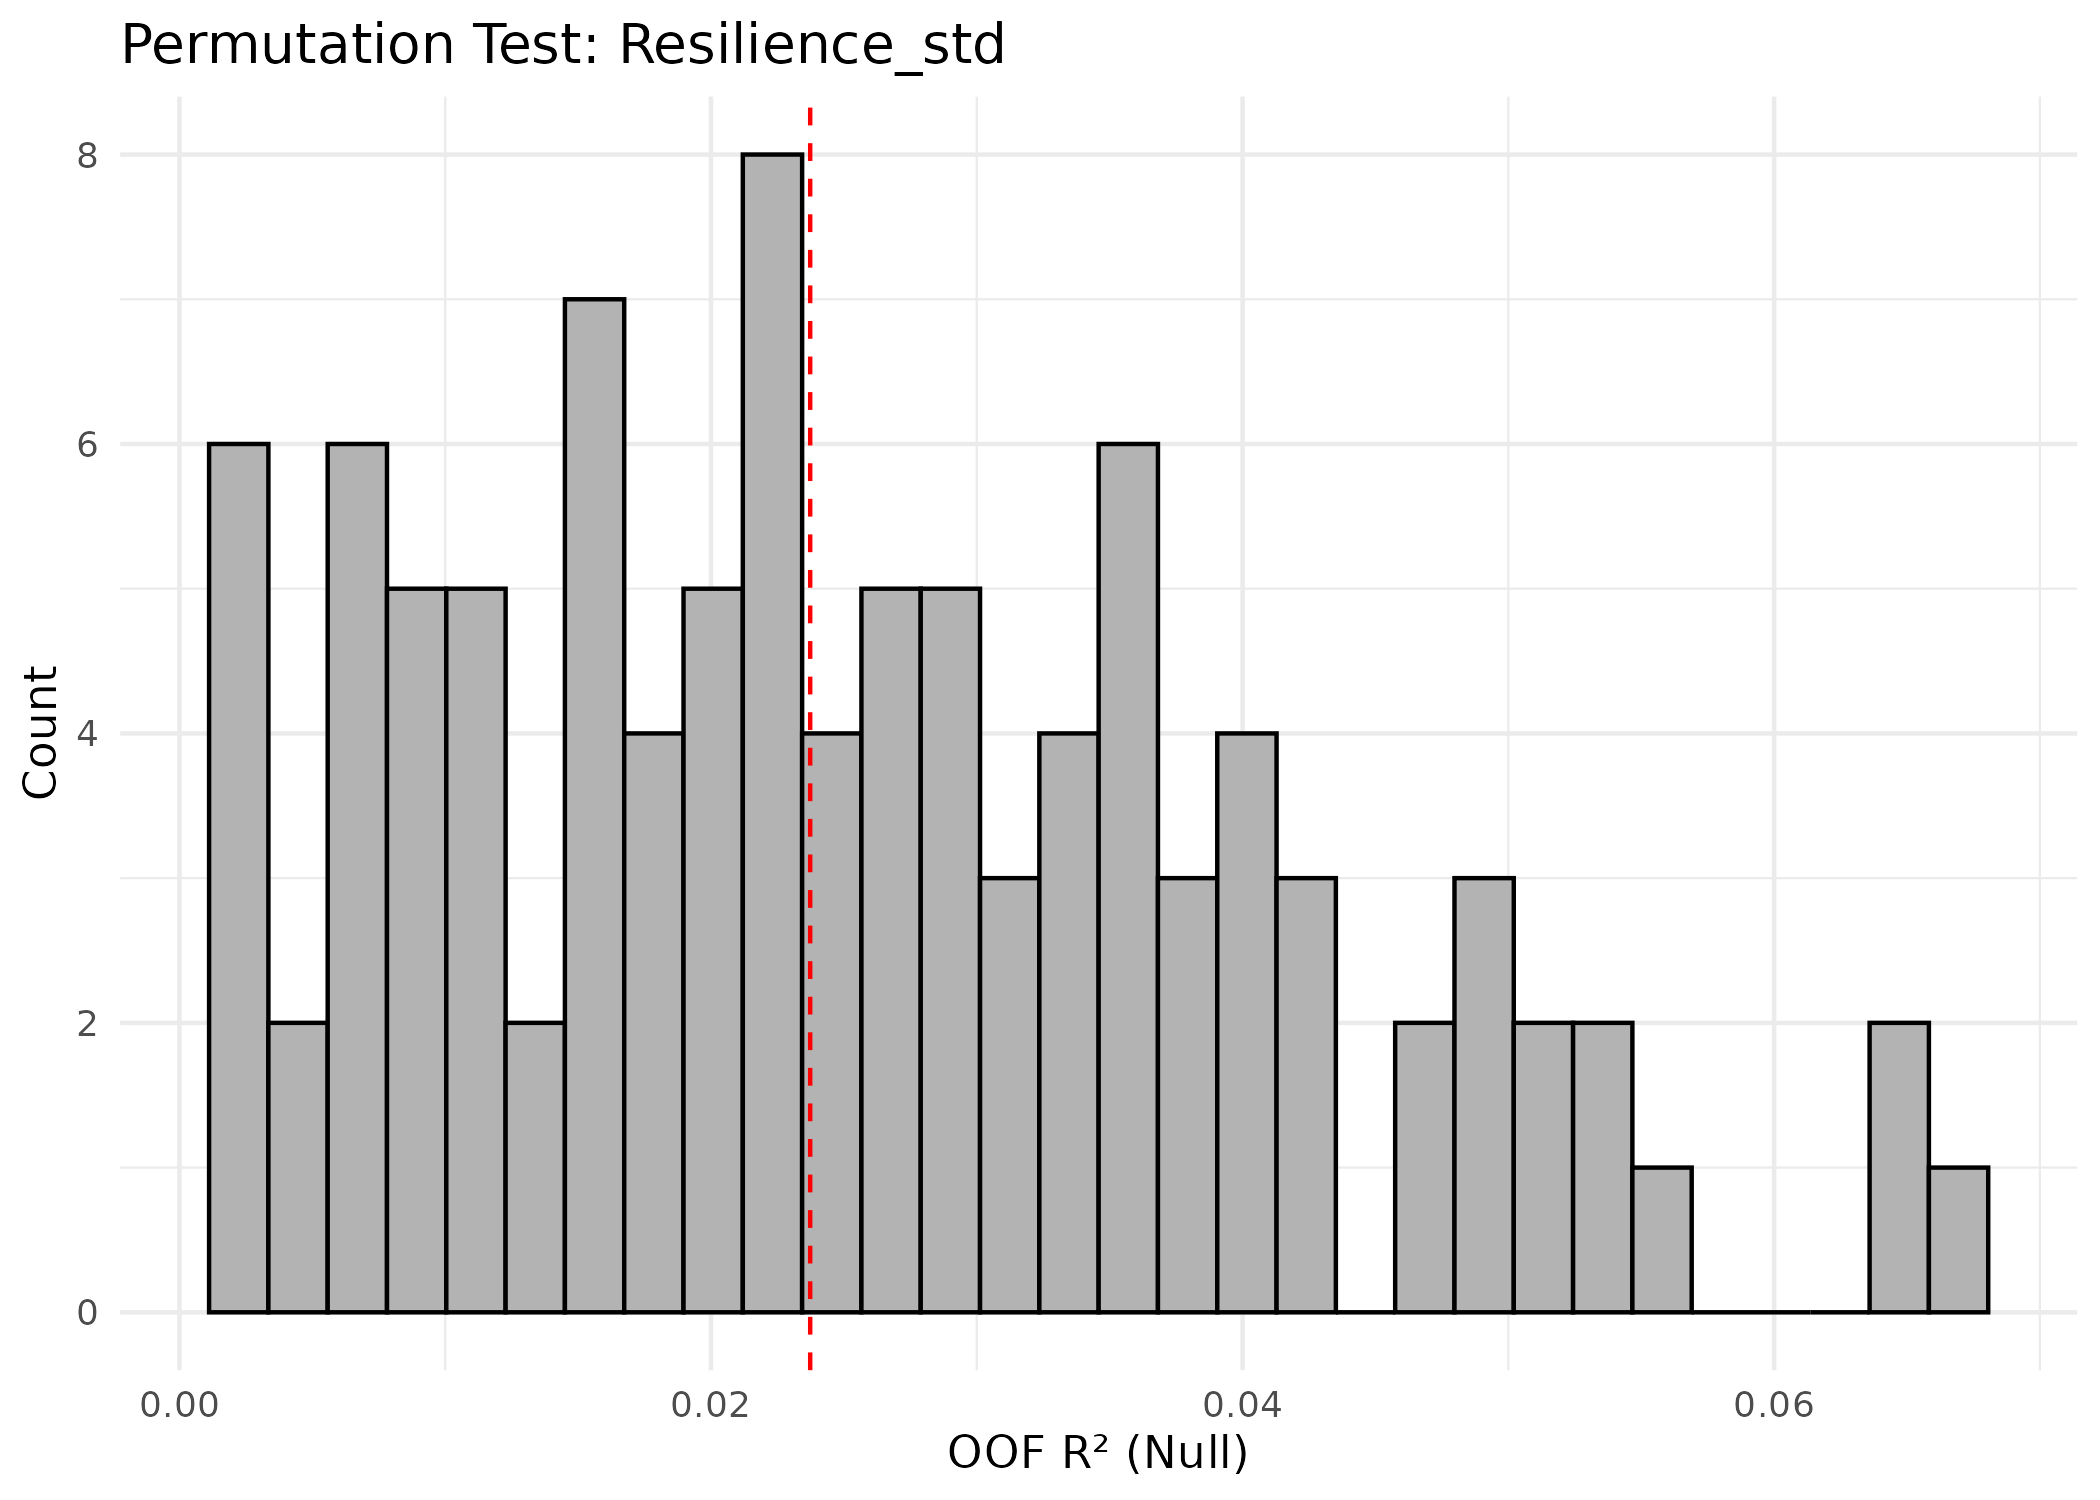

[1] "--- performance_BAG_std.rds (head) ---"
           R2      RMSE Alpha
1 0.004072320 1.0003517   0.1
2 0.010828532 1.0002129   0.2
3 0.019184758 1.0009526   0.1
4 0.001638419 0.9992598   0.1
5 0.001681435 0.9979911   0.9
6 0.014471721 1.0026312   0.1
[1] "--- selection_BAG_std.rds (head) ---"
   Protein SelectionCount SelectionFreq
1 SL006768             81          0.81
2 SL000421             70          0.70
3 SL000398             53          0.53
4 SL000574             25          0.25
5 SL000667             23          0.23
6 SL006318             21          0.21
[1] "--- performance_Resilience_std.rds (head) ---"
           R2     RMSE Alpha
1 0.021843569 1.001304   0.1
2 0.027912433 1.002617   0.3
3 0.020242258 1.001286   0.3
4 0.004655803 0.996987   0.0
5 0.024195729 1.001531   0.1
6 0.033508135 1.002724   1.0
[1] "--- selection_Resilience_std.rds (head) ---"
   Protein SelectionCount SelectionFreq
1 SL001220             17          0.17
2 SL002425             14          0.

In [5]:
# === Lightweight display of saved outputs (no recompute) ===

# 1) Show the text log 
if (file.exists("output/run_log.txt")) {
  cat("----- run_log.txt -----\n")
  cat(readLines("output/run_log.txt"), sep = "\n")
  cat("\n------------------------\n")
} else {
  cat("No run_log.txt found. (Optional; not required.)\n")
}

# 2) Show a few key plots inline
show_png <- function(path) {
  if (file.exists(path)) {
  
    if (requireNamespace("IRdisplay", quietly = TRUE)) {
      IRdisplay::display_png(file = path)
    } else {
      if (!requireNamespace("png", quietly = TRUE)) install.packages("png", repos = "https://cloud.r-project.org")
      if (!requireNamespace("grid", quietly = TRUE)) install.packages("grid", repos = "https://cloud.r-project.org")
      img <- png::readPNG(path)
      grid::grid.newpage(); grid::grid.raster(img)
    }
  } else {
    message("Missing file: ", path)
  }
}

cat("\n=== BAG_std Figures ===\n")
show_png("output/performance_BAG_std.png")
show_png("output/top_selection_BAG_std.png")
show_png("output/alpha_r2_BAG_std.png")
show_png("output/permutation_hist_BAG_std.png")

cat("\n=== Resilience_std Figures ===\n")
show_png("output/performance_Resilience_std.png")
show_png("output/top_selection_Resilience_std.png")
show_png("output/alpha_r2_Resilience_std.png")
show_png("output/permutation_hist_Resilience_std.png")

# 3) Display small table previews from RDS (head only)
safe_head <- function(x, n = 6) {
  x <- as.data.frame(x)
  utils::head(x, n)
}

print("--- performance_BAG_std.rds (head) ---")
print(safe_head(readRDS("output/performance_BAG_std.rds")))

print("--- selection_BAG_std.rds (head) ---")
print(safe_head(readRDS("output/selection_BAG_std.rds")))

print("--- performance_Resilience_std.rds (head) ---")
print(safe_head(readRDS("output/performance_Resilience_std.rds")))

print("--- selection_Resilience_std.rds (head) ---")
print(safe_head(readRDS("output/selection_Resilience_std.rds")))
